In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/My Drive/datasets

/content/gdrive/My Drive/datasets


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import datetime

#import pandas_summary as ps
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('use_inf_as_na', True)
random_state = 17

In [ ]:
df = pd.read_csv('products.csv', sep=',')

In [ ]:
df['user_id'] = pd.factorize(df.user_id)[0] + 1

#General Data Analysis and Preprocessing

order_id
1    8471220
dtype: int64


page_id
1    8471220
dtype: int64


title
banner_show     7393314
banner_click     829184
order            248722
dtype: int64


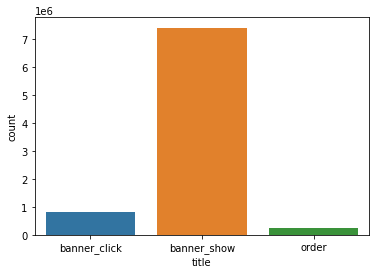

In [ ]:
for i in ('order_id', 'page_id'):
    df[i] = df[i].fillna(0).apply(lambda x: x if x == 0 else 1)
    print(df.groupby([i]).size().sort_values(ascending=False).head(2))
    print('\n')
print(df.groupby(['title']).size().sort_values(ascending=False).head())
sns.countplot('title', data=df)
plt.show();
df.drop(['order_id', 'page_id'], axis=1, inplace=True)

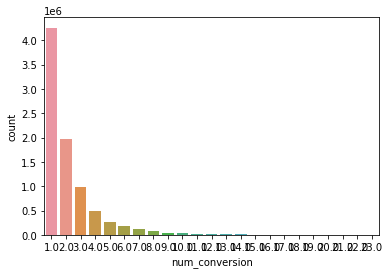

In [ ]:
df = df.assign(num_conversion=df.groupby(['user_id'])['time'].rank(method='first', ascending=True))
sns.countplot('num_conversion', data=df)
plt.show();
df['IsBanner_click'] = df['title'].apply(lambda x: 1 if x == 'banner_click' else 0)
df['IsBanner_click'] = df.groupby('user_id').IsBanner_click.transform(np.mean).apply(lambda x: 0 if x == 0 else 1)
df['IsFirst_conversion'] = df['num_conversion'].apply(lambda x: 1 if x == 1 else 0)
#df.drop(['user_id', 'title'], axis=1, inplace=True)

In [ ]:
df['time'] = pd.to_datetime(df['time'])

In [ ]:
df['time_IsMorning'] = df['time'].apply(lambda ts: 1 if (ts.hour >= 6) and (ts.hour < 10) else 0)
df['time_IsDaylight'] = df['time'].apply(lambda ts: 1 if (ts.hour >= 10) and (ts.hour < 16) else 0)
df['time_IsEvening'] = df['time'].apply(lambda ts: 1 if (ts.hour >= 16) and (ts.hour < 23) else 0)
df['time_Hour'] = df['time'].apply(lambda ts: ts.hour)
df['time_Day'] = df['time'].apply(lambda ts: ts.day)
df['time_Week_Day'] = df['time'].apply(lambda ts: datetime.date(ts.year, ts.month, ts.day).weekday() + 1)
df['time_Year_Month'] = df['time'].apply(lambda ts: ts.year * 100 + ts.month)
df.drop(['time'], axis=1, inplace=True)



product
clothes             1786438
company             1725056
sneakers            1703342
sports_nutrition    1634625
accessories         1621759
dtype: int64


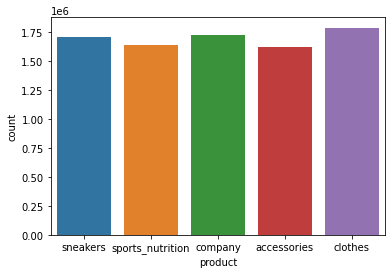



site_version
mobile     6088335
desktop    2382885
dtype: int64


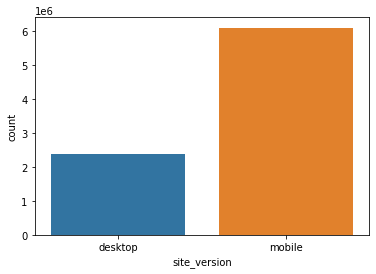

In [ ]:
for i in ['product', 'site_version']:
    print('\n')
    print(df.groupby([i]).size().sort_values(ascending=False).head())
    sns.countplot(i, data=df)
    plt.show()

In [ ]:
df['SV_IsMobile'] = df['site_version'].map({'desktop': 0, 'mobile': 1})
#df.drop(['site_version'], axis=1, inplace=True)

In [ ]:
df = pd.get_dummies(df, columns=['product'])

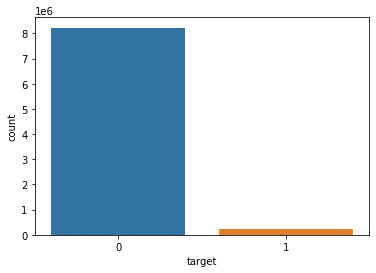

In [ ]:
sns.countplot('target', data=df)
plt.show()

Resampling the data for better analysis


Perc. of banner click or show result:  0.5
Perc. of order result:  0.5
Total number of transactions in resampled data:  497444


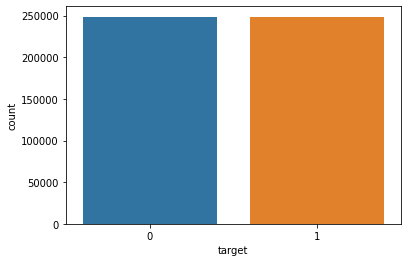

In [ ]:
# Number of data points in the minority class
number_records_fraud = len(df[df.target == 1])
fraud_indices = np.array(df[df.target == 1].index)

# Picking the indices of the normal classes
normal_indices = df[df.target == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dataset
under_sample_data = df.iloc[under_sample_indices,:]

X = under_sample_data.iloc[:, under_sample_data.columns != 'target']
y = under_sample_data.iloc[:, under_sample_data.columns == 'target']

# Showing ratio
print("Perc. of banner click or show result: ", len(under_sample_data[under_sample_data.target == 0])/len(under_sample_data))
print("Perc. of order result: ", len(under_sample_data[under_sample_data.target == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))
sns.countplot('target', data=y)
plt.show()

In [ ]:
df

,user_id,site_version,title,target,State,num_conversion,IsBanner_click,IsFirst_conversion,time_IsMorning,time_IsDaylight,time_IsEvening,time_Hour,time_Day,time_Week_Day,time_Year_Month,SV_IsMobile,product_accessories,product_clothes,product_company,product_sneakers,product_sports_nutrition
0,1,desktop,banner_click,0,GA,1.0,1,1,1,0,0,9,11,5,201901,0,0,0,0,1,0
1,2,desktop,banner_show,0,ME,4.0,1,0,1,0,0,9,9,3,201901,0,0,0,0,1,0
2,2,desktop,banner_show,0,AL,3.0,1,0,1,0,0,9,9,3,201901,0,0,0,0,0,1
3,2,desktop,banner_show,0,CA,1.0,1,1,1,0,0,8,3,4,201901,0,0,0,1,0,0
4,2,desktop,banner_click,0,RI,2.0,1,0,1,0,0,8,3,4,201901,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8471215,4254615,desktop,banner_show,0,AL,1.0,0,1,0,1,0,14,23,4,201905,0,1,0,0,0,0
8471216,4254616,mobile,banner_show,0,KS,1.0,0,1,1,0,0,8,28,2,201905,1,0,1,0,0,0
8471217,4254617,mobile,banner_show,0,VT,1.0,0,1,1,0,0,9,20,1,201905,1,0,0,0,0,1
8471218,4254618,mobile,banner_show,0,MT,1.0,0,1,0,0,1,19,28,2,201905,1,0,0,0,1,0


In [ ]:
X

,user_id,site_version,title,State,num_conversion,IsBanner_click,IsFirst_conversion,time_IsMorning,time_IsDaylight,time_IsEvening,time_Hour,time_Day,time_Week_Day,time_Year_Month,SV_IsMobile,product_accessories,product_clothes,product_company,product_sneakers,product_sports_nutrition
60,20,desktop,order,OK,5.0,1,0,0,1,0,10,3,7,201903,0,0,0,0,0,1
106,34,desktop,order,NJ,9.0,1,0,0,0,1,21,8,5,201902,0,0,0,0,1,0
107,34,desktop,order,ID,10.0,1,0,0,0,1,19,10,7,201902,0,0,1,0,0,0
165,52,mobile,order,UT,3.0,0,0,0,1,0,10,6,3,201902,1,0,0,0,0,1
179,54,mobile,order,ID,1.0,1,1,0,0,1,19,10,7,201902,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5945330,2807062,mobile,banner_show,ME,4.0,1,0,0,0,1,20,11,6,201905,1,0,0,0,1,0
6670552,3200045,mobile,banner_show,ME,1.0,0,1,0,0,0,23,23,6,201903,1,0,0,0,1,0
1782948,750983,mobile,banner_show,OH,1.0,0,1,0,0,0,2,24,7,201902,1,0,0,1,0,0
5492262,2577318,desktop,banner_show,AK,2.0,0,0,0,1,0,10,31,5,201905,0,0,0,0,1,0


In [ ]:
Xc = X.iloc[:,4:]
Xc

,num_conversion,IsBanner_click,IsFirst_conversion,time_IsMorning,time_IsDaylight,time_IsEvening,time_Hour,time_Day,time_Week_Day,time_Year_Month,SV_IsMobile,product_accessories,product_clothes,product_company,product_sneakers,product_sports_nutrition
60,5.0,1,0,0,1,0,10,3,7,201903,0,0,0,0,0,1
106,9.0,1,0,0,0,1,21,8,5,201902,0,0,0,0,1,0
107,10.0,1,0,0,0,1,19,10,7,201902,0,0,1,0,0,0
165,3.0,0,0,0,1,0,10,6,3,201902,1,0,0,0,0,1
179,1.0,1,1,0,0,1,19,10,7,201902,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699280,1.0,0,1,0,1,0,11,4,1,201902,0,0,0,0,1,0
3745307,2.0,0,0,0,0,1,19,30,2,201904,0,1,0,0,0,0
7362173,1.0,0,1,1,0,0,6,15,1,201904,1,1,0,0,0,0
5049055,1.0,0,1,1,0,0,6,23,2,201904,0,0,0,1,0,0


#Naive Bayes Classifier

In [ ]:
df['time'] = df['time'].apply(lambda ts: 'M' if ((ts.hour >= 6) and (ts.hour < 10)) else ('D' if ((ts.hour >= 10) and (ts.hour < 16)) else 'E'))


  




In [ ]:
df.describe()

,product,site_version,time,title
count,8471220,8471220,8471220,8471220
unique,5,2,3,3
top,clothes,mobile,E,banner_show
freq,1786438,6088335,3684137,7393314


In [ ]:
class CategoricalNB():
    def __init__(self, train_df, test_df, label):
        self.X_train, self.y_train = self.split_features_targets(df=train_df, label=label)
        self.X_test, self.y_test = self.split_features_targets(df=test_df, label=label)

        self.X_test_vals = self.X_test.values
        self.y_test_vals = self.y_test.values

        self.X_likelihood, self.y_likelihood = self.compute_likelihood()

    def split_features_targets(self, df, label):
        X = df.drop(columns=[label], axis=1)
        y = df[label]
        return X, y

    def compute_likelihood(self):
        X_likelihood = {}

        yc_df = self.y_train.value_counts().to_frame()
        yc_df.reset_index(inplace=True)
        yc_df.columns = ['class', 'count']

        y_vc = {i : j for (i, j) in zip(yc_df['class'], yc_df['count'])}
        y_vc_k = list(y_vc.keys())

        for col in self.X_train:
            each_col_dict = {}
            x_col_vals = self.X_train[col].value_counts().to_frame().index.to_list()
            fydf = pd.DataFrame(data={col : self.X_train[col], 'y' : self.y_train})

            for ex in x_col_vals:
                each_x_dict = {}
                x_ex_df = fydf[fydf[col] == ex]

                for ey in y_vc_k:
                    x_y_df = x_ex_df[x_ex_df['y'] == ey]
                    each_x_dict[ey] = len(x_y_df) / y_vc[ey]

                each_col_dict[ex] = each_x_dict
            X_likelihood[col] = each_col_dict
        y_likelihood = {i : j / sum(list(y_vc.values())) for (i, j) in y_vc.items()}

        return X_likelihood, y_likelihood

    def predictor(self, X_new):
        cols = list(self.X_likelihood.keys())
        col_new = {i : j for (i, j) in zip(cols, X_new)}

        lprobs = {}
        for l, v in self.y_likelihood.items():
            cate_v = [self.X_likelihood[cn][cl][l] for (cn, cl) in col_new.items()]
            lprobs[l] = round((np.prod(cate_v) * v), 4)

        prob_ks = list(lprobs.keys())
        prob_vs = list(lprobs.values())

        return prob_ks[np.argmax(prob_vs)]

    def predict(self):
        if len(self.X_test_vals) == 1:
            return self.predictor(X_new=self.X_test_vals[0])
        preds = [self.predictor(X_new=i) for i in self.X_test_vals]
        return preds

    def accuracy_score(self, preds):
        actual_vals = np.array(self.y_test_vals)
        preds = np.array(preds)
        corrects = np.count_nonzero(np.where((actual_vals == preds), 1, 0))
        return corrects / len(actual_vals)

In [ ]:
def splitter(dframe, percentage=0.8, random_state=True):
    if random_state:
        dframe = dframe.sample(frac=1)

    thresh = round(len(dframe) * percentage)
    train_df = dframe.iloc[:thresh]
    test_df = dframe.iloc[thresh:]

    return train_df, test_df

In [ ]:
train_df, test_df = splitter(dframe=df)

In [ ]:
nb = CategoricalNB(
    train_df=train_df, 
    test_df=test_df, 
    label='title'
)

In [ ]:
preds = nb.predict()

In [ ]:

acc = nb.accuracy_score(preds=preds)
print(acc)

0.8730383581113464


Naive Bayes was performed on the whole dataset above. However the dataset is skewed and only one class which has marginally higher number of occurences is being predicted and that has given accuracy of 87%. Now we perform the Naive Bayes on a resampled data which has equal instances of both type of targets

In [ ]:
df4 = df[['product','site_version','time','title','target']]

In [ ]:
def condition(ts):
  if (ts.hour >= 6) and (ts.hour < 10):
    return "Morning"
  elif (ts.hour >= 10) and (ts.hour < 16): 
    return "Daylight" 
  else:
     return "Evening"

In [ ]:
df4['time'] = pd.to_datetime(df4['time'])
df4['time1'] = df4['time'].apply(condition)

In [ ]:
df4.drop(['time'], axis=1, inplace=True)

In [ ]:
df4

,product,site_version,title,target,time1
0,sneakers,desktop,banner_click,0,Morning
1,sneakers,desktop,banner_show,0,Morning
2,sports_nutrition,desktop,banner_show,0,Morning
3,company,desktop,banner_show,0,Morning
4,company,desktop,banner_click,0,Morning
...,...,...,...,...,...
8471215,accessories,desktop,banner_show,0,Daylight
8471216,clothes,mobile,banner_show,0,Morning
8471217,sports_nutrition,mobile,banner_show,0,Morning
8471218,sneakers,mobile,banner_show,0,Evening


Perc. of banner click or show result:  0.5
Perc. of order result:  0.5
Total number of transactions in resampled data:  497444


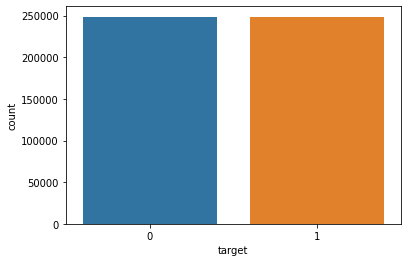

In [ ]:
number_records_fraud = len(df4[df4.target == 1])
fraud_indices = np.array(df4[df4.target == 1].index)

# Picking the indices of the normal classes
normal_indices = df4[df4.target == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dataset
under_sample_data = df4.iloc[under_sample_indices,:]

X1 = under_sample_data.iloc[:, under_sample_data.columns != 'target']
y1 = under_sample_data.iloc[:, under_sample_data.columns == 'target']

# Showing ratio
print("Perc. of banner click or show result: ", len(under_sample_data[under_sample_data.target == 0])/len(under_sample_data))
print("Perc. of order result: ", len(under_sample_data[under_sample_data.target == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))
sns.countplot('target', data=y1)
plt.show()

In [ ]:
X1

,product,site_version,title,time1
60,sports_nutrition,desktop,order,Daylight
106,sneakers,desktop,order,Evening
107,clothes,desktop,order,Evening
165,sports_nutrition,mobile,order,Daylight
179,accessories,mobile,order,Evening
...,...,...,...,...
4799194,clothes,mobile,banner_show,Evening
8190988,accessories,mobile,banner_show,Morning
3934869,sneakers,desktop,banner_show,Evening
14203,accessories,mobile,banner_show,Morning


In [ ]:
cl = X1.title.unique()

In [ ]:
data1 = X1.sample(frac=0.8, random_state=142)
test=X1.drop(data1.index)

In [ ]:
data1 = data1.sample(frac=1).reset_index(drop=True)

In [ ]:
data1

,product,site_version,title,time1
0,sneakers,desktop,order,Evening
1,accessories,desktop,banner_show,Evening
2,sneakers,desktop,order,Daylight
3,accessories,mobile,banner_show,Daylight
4,accessories,mobile,order,Evening
...,...,...,...,...
397950,clothes,mobile,banner_click,Evening
397951,accessories,desktop,order,Daylight
397952,sneakers,mobile,banner_show,Evening
397953,clothes,desktop,order,Evening


In [ ]:
#Prior Probabilities dictionary
def dict_to_pd(coln):
  dic = {}
  for c in cl:
    dic[c] = {}
  m = data1.shape[0]
  for i in range(m):
    for c in cl:
      if c == data1['title'][i]:
        if data1[coln][i] in dic[c]:
          dic[c][data1[coln][i]] += 1
        else:
          dic[c][data1[coln][i]] = 1
        #dic[c].append(sheet1[coln][i])
  #dat=pd.DataFrame.from_dict(dic,orient='index').transpose()
  return dic

In [ ]:
d = {}
class_prior = {}
for c in cl:
  class_prior[c] = list(data1['title']).count(c)
t = sum((class_prior).values())
for c in cl:
  class_prior[c] = class_prior[c]/t
for col in data1.columns:
  if not col == 'title':
    d[col] = dict_to_pd(col)
print(class_prior)
print(d)
for col in data1.columns:
  if not col == 'title':
    for c in cl:
      tot = sum((d[col][c]).values())
      for k in d[col][c].keys():
        d[col][c][k] = d[col][c][k]/tot
print(d)

{'order': 0.5002073098717191, 'banner_show': 0.44936236509153044, 'banner_click': 0.050430325036750386}
{'product': {'order': {'sneakers': 54154, 'accessories': 35702, 'clothes': 90150, 'sports_nutrition': 19054}, 'banner_show': {'accessories': 34661, 'clothes': 34862, 'sports_nutrition': 35663, 'sneakers': 35461, 'company': 38179}, 'banner_click': {'sneakers': 4467, 'accessories': 3316, 'clothes': 5221, 'company': 3512, 'sports_nutrition': 3553}}, 'site_version': {'order': {'desktop': 106722, 'mobile': 92338}, 'banner_show': {'desktop': 51223, 'mobile': 127603}, 'banner_click': {'mobile': 17295, 'desktop': 2774}}, 'time1': {'order': {'Evening': 113646, 'Daylight': 58668, 'Morning': 26746}, 'banner_show': {'Evening': 76856, 'Daylight': 55191, 'Morning': 46779}, 'banner_click': {'Daylight': 6251, 'Morning': 5161, 'Evening': 8657}}}
{'product': {'order': {'sneakers': 0.27204862855420475, 'accessories': 0.17935295890686226, 'clothes': 0.4528785290867075, 'sports_nutrition': 0.095719883452

In [ ]:
#naive bayes classifier
test = test.sample(frac=1).reset_index(drop=True)
classify = []
for i in range(test.shape[0]):
  prob = {}
  for c in cl:
    p = class_prior[c]
    for col in test.columns:
      if not col == 'title':
        att = test[col][i]
        #print(att)
        try:
          p *= d[col][c][att]
        except:
          p = 0
      prob[c] = p
  #print(prob)
  classify.append(max(prob, key = prob.get))
print(classify)

['order', 'order', 'order', 'order', 'order', 'banner_show', 'order', 'banner_show', 'order', 'order', 'banner_show', 'order', 'order', 'order', 'order', 'order', 'order', 'banner_show', 'banner_show', 'order', 'banner_show', 'banner_show', 'banner_show', 'order', 'banner_show', 'order', 'banner_show', 'order', 'banner_show', 'banner_show', 'banner_show', 'order', 'banner_show', 'order', 'order', 'order', 'order', 'order', 'banner_show', 'order', 'banner_show', 'banner_show', 'banner_show', 'order', 'banner_show', 'banner_show', 'banner_show', 'order', 'banner_show', 'order', 'banner_show', 'banner_show', 'order', 'order', 'banner_show', 'order', 'order', 'banner_show', 'order', 'order', 'banner_show', 'order', 'banner_show', 'order', 'order', 'order', 'banner_show', 'banner_show', 'order', 'banner_show', 'order', 'banner_show', 'order', 'order', 'banner_show', 'order', 'order', 'banner_show', 'order', 'order', 'order', 'order', 'order', 'order', 'banner_show', 'order', 'order', 'banne

In [ ]:
#naive bayes classifier
test = test.sample(frac=1).reset_index(drop=True)
classify = []
for i in range(test.shape[0]):
  prob = {}
  for c in cl:
    p = class_prior[c]
    for col in test.columns:
      if not col == 'title':
        att = test[col][i]
        #print(att)
        try:
          p *= d[col][c][att]
        except:
          p = 0
      prob[c] = p
  #print(prob)
  classify.append(max(prob, key = prob.get))
print(classify)

['banner_show', 'banner_show', 'order', 'banner_show', 'order', 'order', 'order', 'order', 'order', 'banner_show', 'order', 'banner_show', 'order', 'banner_show', 'order', 'banner_show', 'order', 'banner_show', 'order', 'banner_show', 'order', 'banner_show', 'order', 'banner_show', 'order', 'order', 'order', 'order', 'order', 'order', 'order', 'banner_show', 'order', 'banner_show', 'order', 'order', 'banner_show', 'banner_show', 'order', 'banner_show', 'order', 'order', 'banner_show', 'order', 'banner_show', 'banner_show', 'banner_show', 'order', 'order', 'order', 'order', 'banner_show', 'order', 'banner_show', 'order', 'banner_show', 'order', 'order', 'order', 'banner_show', 'order', 'order', 'order', 'banner_show', 'banner_show', 'banner_show', 'order', 'order', 'order', 'banner_show', 'banner_show', 'banner_show', 'order', 'order', 'banner_show', 'order', 'banner_show', 'order', 'order', 'banner_show', 'order', 'order', 'order', 'order', 'order', 'banner_show', 'banner_show', 'banne

In [ ]:
y_actual = pd.Series(list(test['title']), name= 'Actual' )
y_pred = pd.Series(classify, name= 'Predicted' )
confmat = pd.crosstab(y_actual,y_pred)
cla = list(confmat.columns)

In [ ]:
confmat #0.6677 accuracy value

Predicted,banner_show,order
Actual,,
banner_click,3382,1692
banner_show,29415,15338
order,12647,37015


#SVM Classifier + PCA

In [ ]:
X1 = X1.sample(frac=1).reset_index(drop=True)
num = min(X1['title'].value_counts())
new_df = X1.groupby('title').apply(lambda x: x.sample(n=num)).reset_index(drop = True)

In [ ]:
from seaborn import load_dataset
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

# Load the data and create training and testing data

X = new_df.drop(columns = ['title'])
y = new_df['title']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 100)

# Create a transformer object
column_transformer = make_column_transformer(
    (OneHotEncoder(), ['product', 'site_version','time1']), remainder='passthrough')

# Transform the training features
X_train = column_transformer.fit_transform(X_train)
X_train = pd.DataFrame(data=X_train, columns=column_transformer.get_feature_names_out())
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
# Building and fit the classifier


In [ ]:
principalDf

,principal component 1,principal component 2
0,-0.078385,-0.714162
1,-0.623740,0.187842
2,-0.328641,-0.741514
3,-0.288885,-0.733813
4,1.244979,-0.323111
...,...,...
56083,-0.670280,0.613521
56084,0.910124,0.598544
56085,1.004177,-0.348357
56086,1.244979,-0.323111


In [ ]:
params = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

clf2 = GridSearchCV(
    estimator=SVC(),
    param_grid=params,
    cv=5,
    n_jobs=5,
    verbose=1
)

clf2.fit(X_train1, y_train1)
print(clf2.best_params_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}


In [ ]:
clf = SVC(kernel='rbf', gamma=0.01, C=1000)
clf.fit(principalDf, y_train)

# Transform the training data
X_test = column_transformer.transform(X_test)
X_test = pd.DataFrame(data=X_test, columns=column_transformer.get_feature_names_out())
pca1 = PCA(n_components=2)
principalComponents1 = pca.fit_transform(X_test)
principalDf1 = pd.DataFrame(data = principalComponents1
             , columns = ['principal component 1', 'principal component 2'])
# Make predictions and check the accuracy
predictions = clf.predict(principalDf1)
print(accuracy_score(y_test, predictions))

0.4637355584082157


In [ ]:
rows = new_df.sample(frac =.25)
X3 = rows.drop(columns = ['title'])
y3 = rows['title']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X3, y3, random_state = 100)

# Create a transformer object
column_transformer2 = make_column_transformer(
    (OneHotEncoder(), ['product', 'site_version','time1']), remainder='passthrough')

# Transform the training features
X_train1 = column_transformer2.fit_transform(X_train1)
X_train1 = pd.DataFrame(data=X_train1, columns=column_transformer2.get_feature_names_out())

# Building and fit the classifier
clf1 = SVC(kernel='rbf', gamma=0.01, C=1000)
clf1.fit(X_train1, y_train1)

# Transform the training data
X_test1 = column_transformer2.transform(X_test1)
X_test1 = pd.DataFrame(data=X_test1, columns=column_transformer2.get_feature_names_out())

# Make predictions and check the accuracy
predictions1 = clf1.predict(X_test1)
print(accuracy_score(y_test1, predictions1))

0.506418485237484


#Feature Selection+ Random Forest and XGB Classifiers

In [ ]:
class Feat_Importance:
    df = None
    columns = None
    random_state = None
    ranks = {}
        
    def __init__(self, X, y, columns, random_state=56, show_dict='N', show_plot='N'):
        self.X = X
        self.y = y
        self.names = columns
        self.random_state = random_state
        self.show_dict = show_dict
        self.show_plot = show_plot
        
    def __rank_to_dict(self, ranks, names, order=1):
        minmax = MinMaxScaler()
        ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
        ranks = map(lambda x: round(x, 2), ranks)
        return dict(zip(names, ranks))
    
    def feat_stats(self):
        self.ranks = {}
        self.get_KBest()
        self.get_LogReg()
        self.get_XGBC()
        
    def get_KBest(self):
        selector = SelectKBest(f_classif)
        selector.fit(self.X, self.y)
        scores = selector.scores_
        scores = pd.Series(scores).fillna(0)
        self.ranks["KBest"] = self.__rank_to_dict(scores, self.names)
        if self.show_dict == 'Y': 
            print('===== KBest dict =====\n', self.ranks["KBest"], '\n\n\n')
        if self.show_plot == 'Y': 
            print('===== KBest plot =====\n', self.X.shape)
            plt.bar(range(len(self.names)), -np.log10(selector.pvalues_))
            plt.xticks(range(len(self.names)), self.names, rotation='vertical');
            
    def get_LogReg(self):
        model_LogRegRidge = LogisticRegression(penalty='l2', C=0.15, 
                                               random_state=self.random_state, solver='liblinear', 
                                               n_jobs=-1)
        model_LogRegRidge.fit(self.X, self.y)
        self.ranks["LogRegRidge"] = self.__rank_to_dict(list(map(float, 
                                    model_LogRegRidge.coef_.reshape(len(self.names), -1))),
                                    self.names, order=1)
        
        if self.show_dict == 'Y': 
            print('===== LogRegRidge dict =====\n', self.ranks["LogRegRidge"], '\n\n\n')
        if self.show_plot == 'Y':
            print('===== LogRegRidge plot =====\n', self.X.shape)
            listsRidge = sorted(self.ranks["LogRegRidge"].items(), key=operator.itemgetter(1))
            dfRidge = pd.DataFrame(np.array(listsRidge).reshape(len(listsRidge), 2),
                       columns=['Features', 'Ranks']).sort_values('Ranks')
            dfRidge['Ranks'] = dfRidge['Ranks'].astype(float)
            dfRidge.plot.bar(x='Features', y='Ranks', color='blue')
            plt.xticks(rotation=90)
    
    def get_XGBC(self):
        model_XGBC = XGBClassifier(objective='binary:logistic',
                           max_depth=7, min_child_weight=5,
                           gamma=0, random_state=random_state, n_jobs=-1,
                           learning_rate=0.1, n_estimators=200)
        model_XGBC.fit(self.X, self.y)
        self.ranks["XGBC"] = self.__rank_to_dict(model_XGBC.feature_importances_, self.names)
        if self.show_dict == 'Y': 
            print('===== XGBClassifier dict =====\n', self.ranks["XGBC"], '\n\n\n')
        if self.show_plot == 'Y':
            print('===== XGBClassifier plot =====\n', self.X.shape)
            plot_importance(model_XGBC)
            plt.show()
    
    def stats_df(self):
        r = {}
        for name in self.names:
            r[name] = round(np.mean([self.ranks[method][name] for method in self.ranks.keys()]), 2)
        methods = sorted(self.ranks.keys())
        self.ranks['Mean'] = r
        methods.append('Mean')

        row_index, AllFeatures_columns = 0, ['Feature', 'Scores']
        AllFeats = pd.DataFrame(columns=AllFeatures_columns)
        for name in self.names:
            AllFeats.loc[row_index, 'Feature'] = name
            AllFeats.loc[row_index, 'Scores'] = [self.ranks[method][name] for method in methods]
            row_index += 1
        AllFeatures_only = pd.DataFrame(AllFeats.Scores.tolist(), )
        AllFeatures_only.rename(columns={0: 'KBest', 1: 'LogRegRidge', 2: 'XGB Classifier', 3: 'Mean'}, inplace=True)
        AllFeatures_only = AllFeatures_only[['KBest', 'LogRegRidge', 'XGB Classifier', 'Mean']]
        AllFeatures_compare = AllFeats.join(AllFeatures_only).drop(['Scores'], axis=1)
        return AllFeatures_compare
    
    def simple_test(self):
        x_train, x_valid, y_train, y_valid = train_test_split(self.X, self.y, test_size=0.3, random_state=random_state+37)
        mods = ('BernoulliNB', 'KNeighborsClassifier', 'RandomForestClassifier')
        for nu, model in enumerate([BernoulliNB(), KNeighborsClassifier(n_jobs=-1), 
                      RandomForestClassifier(n_jobs=-1)]):
            model.fit(x_train, y_train)
            predicted = model.predict(x_valid)
            print(mods[nu])
            print('------ accuracy ------\n', metrics.accuracy_score(y_valid, predicted))
            #print('------ confusion_matrix ------\n', metrics.confusion_matrix(y_valid, predicted))
            print('------ roc_auc_score ------\n', metrics.roc_auc_score(y_valid, predicted))
            print('\n')

In [ ]:
fi = Feat_Importance(Xc, y, Xc.columns)
fi.feat_stats()
fi_df = fi.stats_df()
display(fi_df.sort_values(by=['Mean'], ascending=[False]))

,Feature,KBest,LogRegRidge,XGB Classifier,Mean
13,product_company,1.00,0.00,1.00,0.67
12,product_clothes,0.58,1.00,0.04,0.54
1,IsBanner_click,0.16,0.87,0.04,0.36
10,SV_IsMobile,0.57,0.46,0.06,0.36
14,product_sneakers,0.06,0.93,0.01,0.33
15,product_sports_nutrition,0.16,0.76,0.03,0.32
11,product_accessories,0.00,0.87,0.00,0.29
0,num_conversion,0.12,0.72,0.01,0.28
2,IsFirst_conversion,0.10,0.68,0.00,0.26
6,time_Hour,0.00,0.72,0.01,0.24


In [ ]:
stand_X = Xc[fi_df[fi_df['Mean'] > 0.22].Feature.values]
stand_X.shape

(497444, 13)

In [ ]:
fi = Feat_Importance(stand_X, y, stand_X.columns)
fi.feat_stats()
fi_df = fi.stats_df()
display(fi_df.sort_values(by=['Mean'], ascending=[False]))

,Feature,KBest,LogRegRidge,XGB Classifier,Mean
10,product_company,1.00,0.00,1.00,0.67
9,product_clothes,0.58,1.00,0.04,0.54
1,IsBanner_click,0.16,0.88,0.05,0.36
7,SV_IsMobile,0.57,0.45,0.07,0.36
11,product_sneakers,0.06,0.93,0.01,0.33
12,product_sports_nutrition,0.16,0.75,0.04,0.32
8,product_accessories,0.00,0.86,0.00,0.29
0,num_conversion,0.12,0.72,0.01,0.28
2,IsFirst_conversion,0.10,0.68,0.00,0.26
3,time_Hour,0.00,0.71,0.01,0.24


In [ ]:
fi.simple_test()

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(stand_X, y, test_size=0.3, random_state=random_state)

In [ ]:
r_for = RandomForestClassifier()
print(r_for)
for_params = {'max_depth': np.arange(4, 10), 'max_features': np.arange(0.25, 0.5, 1), 'n_estimators': [30, 50, 60]}
for_grid = GridSearchCV(r_for, for_params, cv=2, n_jobs=-1)
for_grid.fit(x_train, y_train)
print('best score / best params: ', for_grid.best_score_, for_grid.best_params_)
y_pred = for_grid.predict(x_valid)
print('classification_report: \n', metrics.classification_report(y_pred, y_valid))
print('accuracy_score: ', metrics.accuracy_score(y_pred, y_valid))
print('roc_auc_score: ', metrics.roc_auc_score(y_pred, y_valid))

RandomForestClassifier()
best score / best params:  0.760529565492088 {'max_depth': 9, 'max_features': 0.25, 'n_estimators': 50}
classification_report: 
               precision    recall  f1-score   support

           0       0.72      0.78      0.75     67979
           1       0.80      0.74      0.77     81255

    accuracy                           0.76    149234
   macro avg       0.76      0.76      0.76    149234
weighted avg       0.76      0.76      0.76    149234

accuracy_score:  0.7603763217497354
roc_auc_score:  0.76228274386217


In [ ]:
xgb_m = XGBClassifier()
xgb_params = [
    {"n_estimators": [300, 350],
     "max_depth": [3,  5],
     "learning_rate": [0.01, 0.05]}
]
xgb_grid = GridSearchCV(xgb_m, xgb_params, cv=2, refit=True, verbose=1, n_jobs=-1)
xgb_grid.fit(x_train, y_train)
print('best score / best params: ', xgb_grid.best_score_, xgb_grid.best_params_)
y_pred = xgb_grid.predict(x_valid)
print('classification_report: \n', metrics.classification_report(y_pred, y_valid))
print('accuracy_score: ', metrics.accuracy_score(y_pred, y_valid))
print('roc_auc_score: ', metrics.roc_auc_score(y_pred, y_valid))

Fitting 2 folds for each of 8 candidates, totalling 16 fits
best score / best params:  0.7663823554751443 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300}
classification_report: 
               precision    recall  f1-score   support

           0       0.73      0.79      0.76     68433
           1       0.81      0.75      0.78     80801

    accuracy                           0.77    149234
   macro avg       0.77      0.77      0.77    149234
weighted avg       0.77      0.77      0.77    149234

accuracy_score:  0.7662194942171355
roc_auc_score:  0.7679018661404444


#Clustering analysis

In [ ]:
import cmath as math
import random
from random import randint
from scipy import linalg, sparse
data = Xc.values
N = Xc.shape[1]
M = Xc.shape[0]

In [ ]:
stand_X = pd.DataFrame(preprocessing.scale(Xc), columns=Xc.columns)

In [ ]:
def labelling(x,p,cluster_index):
  x1 = np.column_stack([x,cluster_index])
  clusters = np.zeros((p,1))
  clusters = clusters.tolist()
  #cluster_index=np.zeros((20,1))
  #cluster_index = cluster_index.tolist()
  l = x1.shape[1]-1
  for k in range(x.shape[0]):
    for j in range(1,p+1):
      if x1[k][l] == j:
        if (type(clusters[j-1][0]) == float):
          clusters[j-1][0]= x1[k, 0:l].tolist()
          #cluster_index[j-1][0]= k
        else:
          clusters[j-1].append(x1[k, 0:l].tolist())
          #cluster_index[j-1].append(k)
  return clusters

In [ ]:
def cl_centers(p,clusters):
  cluster_centres = np.zeros((p,N))
  for cl in range(len(clusters)):
    clusters[cl] = np.array(clusters[cl])
    cluster_centres[cl] = (clusters[cl]).mean(0)
  return cluster_centres

In [ ]:
def updation(x,p,cluster_centres):
  dev = np.zeros((p,N))
  arg = np.zeros((p,1))
  updated_cluster_index = []
  for i in range(len(x)):
    for j in range(len(cluster_centres)):
      dev = x[i] - cluster_centres[j]
      arg[j] = (np.linalg.norm(dev))**2
    ind = np.argmin(arg)
    updated_cluster_index.append(ind+1)
  return updated_cluster_index

In [ ]:
def kmeans(X,p):
  n = X.shape[0]
  randindex = np.random.randint(1,p+1,n)
  print("Iteration 1")
  print(randindex.tolist())
  randindex = np.array(randindex, copy=False, subok=True, ndmin=2).T
  clus = labelling(X,p,randindex)
  c_mean = cl_centers(p,clus)
  newindex = updation(X,p,c_mean)
  termination = np.zeros((n,1))
  iter = 1
  c = 0
  while True:
    iter +=1
    clus = labelling(X,p,newindex)
    c_mean = cl_centers(p,clus)
    oldindex = newindex
    newindex = updation(X,p,c_mean)
    print("Iteration ",iter)
    print(newindex)
    ter_cond = np.array(newindex)-np.array(oldindex)
    if all([ v == 0 for v in ter_cond]):
      c += 1
      if c == 10:
        break
      else:
        continue
    else:
      continue
      c = 0
    #if iter == 300:
      #break
    #else:
      #continue
  return newindex

In [ ]:
data

array([[ 5.,  1.,  0., ...,  0.,  0.,  1.],
       [ 9.,  1.,  0., ...,  0.,  1.,  0.],
       [10.,  1.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 1.,  0.,  1., ...,  1.,  0.,  0.],
       [ 2.,  0.,  0., ...,  0.,  1.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  1.]])

In [ ]:
cluster_stand_df = stand_X
cluster_stand_df['target'] = preprocessing.scale(y)
cl_index = kmeans(data,3)


In [ ]:
unique, counts = np.unique(cl_index, return_counts=True)
print(np.asarray((unique, counts)).T)

[[     1 218937]
 [     2 135567]
 [     3 142940]]


In [ ]:
cluster_df = X[[i for i in stand_X.columns if i != 'target']]
cluster_df['target'] = y
cluster_df['Cluster'] = cl_index
cluster_df['Cluster'].value_counts(normalize=True)

1    0.440124
3    0.287349
2    0.272527
Name: Cluster, dtype: float64

Since we are doing clustering on a binary data (i.e. 0s and 1s) for most of the features, taking a mean of the dataframe columnwise would represent the number of positive instances (i.e occurences of 1) of the feature with respect to each cluster. This would effectively mean the percentage of customers for whom that particular condition would hold true. From this we can infer the most popular tasks/choices of the customers in each cluster. This process is known as customer segmentation, which is the process of dividing customers into groups based on common characteristics so companies can market to each group effectively and appropriately.

In [ ]:
cluster_df.groupby('Cluster').mean().sort_values(by=['target'], ascending=False)

,num_conversion,IsBanner_click,IsFirst_conversion,time_IsMorning,time_IsDaylight,time_IsEvening,time_Hour,time_Day,time_Week_Day,time_Year_Month,SV_IsMobile,product_accessories,product_clothes,product_company,product_sneakers,product_sports_nutrition,target
Cluster,,,,,,,,,,,,,,,,,
3,2.552148,0.413131,0.415706,0.000000,0.290919,0.653988,17.537799,22.587169,3.989639,201903.173178,0.583378,0.185371,0.339149,0.095250,0.238310,0.141920,0.538527
1,2.323239,0.406688,0.472839,0.192795,0.334265,0.332146,12.699516,7.361698,3.996054,201903.289028,0.596044,0.185094,0.325770,0.107090,0.235442,0.146604,0.493644
2,2.472438,0.404331,0.433424,0.412490,0.261546,0.000000,6.844431,21.929821,3.977266,201903.190223,0.603753,0.185539,0.322033,0.111229,0.234792,0.146407,0.469642


#Market Basket Analysis to analyse customer buying patterns

In [ ]:
df2 = pd.read_csv('products.csv', sep=',')

In [ ]:
df2['user_id'] = pd.factorize(df2.user_id)[0] + 1

In [ ]:
df1 = df2[(df2.target == 1)][['user_id','product']]
df1 = df1.sample(frac=1).reset_index(drop=True)
df1

,user_id,product
0,2167182,accessories
1,2622729,clothes
2,1904440,accessories
3,837769,clothes
4,2375208,sneakers
...,...,...
248717,3838396,sneakers
248718,2597716,sneakers
248719,2382720,clothes
248720,3635352,sports_nutrition


In [ ]:
transaction = {}
m = df1.shape[0]
for i in range(m):
  if df1['user_id'][i] not in transaction:
    transaction[df1['user_id'][i]] = {df1['product'][i]}
  else:
    transaction[df1['user_id'][i]].add(df1['product'][i])

In [ ]:
transaction # orders for each user id

{2167182: {'accessories'},
 2622729: {'clothes'},
 1904440: {'accessories'},
 837769: {'clothes'},
 2375208: {'sneakers'},
 1268343: {'clothes'},
 1746148: {'sneakers'},
 1543343: {'clothes'},
 1629040: {'accessories'},
 503314: {'sneakers'},
 3471250: {'sports_nutrition'},
 1777865: {'clothes'},
 1790794: {'sneakers'},
 1790726: {'clothes'},
 1556012: {'sneakers'},
 2174423: {'sneakers'},
 3282150: {'clothes'},
 197094: {'accessories'},
 4202353: {'clothes'},
 2511632: {'sneakers'},
 2147859: {'sports_nutrition'},
 2101345: {'sneakers'},
 2582072: {'sneakers'},
 2273073: {'clothes'},
 237662: {'clothes'},
 1638877: {'sneakers'},
 4113824: {'sports_nutrition'},
 2815498: {'sneakers'},
 1899317: {'accessories'},
 3656419: {'accessories'},
 3038762: {'sneakers'},
 3620526: {'sports_nutrition'},
 2184570: {'clothes'},
 1030170: {'clothes'},
 1314018: {'clothes'},
 182547: {'clothes'},
 3218448: {'accessories'},
 3591662: {'sneakers'},
 3350783: {'clothes'},
 2184546: {'accessories'},
 259

In [ ]:
def powerSet(items):
    """
    Power set generator: get all possible combinations of a list’s elements

    Input:
        items is a list
    Output:
        returns 2**n combination lists one at a time using a generator 

    Reference: edx.org 6.00.2x Lecture 2 - Decision Trees and dynamic programming
    """

    N = len(items)
    # enumerate the 2**N possible combinations
    for i in range(2**N):
        combo = set()
        for j in range(N):
            # test bit jth of integer i
            if (i >> j) % 2 == 1:
                combo.add(items[j])
        yield combo

In [ ]:
powset = set()
for k in transaction:
  for i in powerSet(list(transaction[k])):
    powset.add(frozenset(i)) # all combination of items of all possible lengths in the transaction stored in a set without repetition

In [ ]:
powset

{frozenset(),
 frozenset({'accessories', 'sneakers'}),
 frozenset({'accessories', 'clothes', 'sports_nutrition'}),
 frozenset({'sneakers'}),
 frozenset({'sports_nutrition'}),
 frozenset({'sneakers', 'sports_nutrition'}),
 frozenset({'clothes'}),
 frozenset({'clothes', 'sports_nutrition'}),
 frozenset({'clothes', 'sneakers', 'sports_nutrition'}),
 frozenset({'accessories'}),
 frozenset({'accessories', 'clothes', 'sneakers'}),
 frozenset({'accessories', 'sports_nutrition'}),
 frozenset({'accessories', 'sneakers', 'sports_nutrition'}),
 frozenset({'accessories', 'clothes'}),
 frozenset({'clothes', 'sneakers'}),
 frozenset({'accessories', 'clothes', 'sneakers', 'sports_nutrition'})}

In [ ]:
lattice = dict()
for ele in powset:
  if len(ele) not in lattice:
    lattice[len(ele)] = [set(ele)]
  else:
    lattice[len(ele)].append(set(ele)) # lattice of k-itemsets generated from the powerset

In [ ]:
lattice

{0: [set()],
 1: [{'sneakers'}, {'sports_nutrition'}, {'accessories'}, {'clothes'}],
 2: [{'accessories', 'sneakers'},
  {'sneakers', 'sports_nutrition'},
  {'accessories', 'sports_nutrition'},
  {'accessories', 'clothes'},
  {'clothes', 'sports_nutrition'},
  {'clothes', 'sneakers'}],
 3: [{'accessories', 'clothes', 'sports_nutrition'},
  {'clothes', 'sneakers', 'sports_nutrition'},
  {'accessories', 'clothes', 'sneakers'},
  {'accessories', 'sneakers', 'sports_nutrition'}],
 4: [{'accessories', 'clothes', 'sneakers', 'sports_nutrition'}]}

In [ ]:
support = dict()
#c = 0
for n in lattice.keys():
  for j in lattice[n]:
    count = 0
    for k in transaction:
      if j.issubset(transaction[k]):
        count +=1
    #c += count
    support[frozenset(j)] = count/len(transaction) #support of each combination of itemsets found
  #for s in support:
    #if support[s]<0.001:
      #for l in lattice:
        #for p in lattice[l]:
          #f set(s).issubset(p):
            #lattice[l].remove(p) # sets less than minsup and associated supersets which they are part of are pruned by apriori principle

In [ ]:
support

{frozenset(): 1.0,
 frozenset({'accessories', 'sneakers'}): 0.00470853337593435,
 frozenset({'sneakers', 'sports_nutrition'}): 0.0024131233551663543,
 frozenset({'accessories', 'sports_nutrition'}): 0.0018371688261458131,
 frozenset({'clothes'}): 0.46390404681627473,
 frozenset({'accessories', 'clothes'}): 0.007327655066297832,
 frozenset({'clothes', 'sports_nutrition'}): 0.0040569059890862924,
 frozenset({'sneakers'}): 0.28132225706910613,
 frozenset({'clothes', 'sneakers'}): 0.01090529962247652,
 frozenset({'sports_nutrition'}): 0.09925336113610184,
 frozenset({'accessories',
            'clothes',
            'sports_nutrition'}): 0.00020179428754004355,
 frozenset({'clothes', 'sneakers', 'sports_nutrition'}): 0.0002606509547392229,
 frozenset({'accessories'}): 0.18565074453684008,
 frozenset({'accessories', 'clothes', 'sneakers'}): 0.0005549342907351198,
 frozenset({'accessories',
            'sneakers',
            'sports_nutrition'}): 0.00013452952502669572,
 frozenset({'accesso

In [ ]:
lattice

{0: [set()],
 1: [{'sneakers'}, {'sports_nutrition'}, {'accessories'}, {'clothes'}],
 2: [{'accessories', 'sneakers'},
  {'sneakers', 'sports_nutrition'},
  {'accessories', 'sports_nutrition'},
  {'accessories', 'clothes'},
  {'clothes', 'sports_nutrition'},
  {'clothes', 'sneakers'}],
 3: [{'accessories', 'clothes', 'sports_nutrition'},
  {'clothes', 'sneakers', 'sports_nutrition'},
  {'accessories', 'clothes', 'sneakers'},
  {'accessories', 'sneakers', 'sports_nutrition'}],
 4: [{'accessories', 'clothes', 'sneakers', 'sports_nutrition'}]}

In [ ]:
association_rules= dict()
lift = dict()
for l in lattice[2]:
  el = list(l)
  #print(set(el))
  d = set()
  li = set()
  d.add(el[0])
  li.add(el[1])
  association_rules[(el[0],el[1])] = support[frozenset(l)]/support[frozenset(d)]
  lift[(el[0],el[1])] = association_rules[(el[0],el[1])]/support[frozenset(li)]
  d.remove(el[0])
  li.remove(el[1])
  d.add(el[1])
  li.add(el[0])
  association_rules[(el[1],el[0])] = support[frozenset(l)]/support[frozenset(d)]
  lift[(el[1],el[0])] = association_rules[(el[1],el[0])]/support[frozenset(li)]

In [ ]:
association_rules

{('accessories', 'clothes'): 0.03947010869565217,
 ('accessories', 'sneakers'): 0.02536231884057971,
 ('accessories', 'sports_nutrition'): 0.009895833333333333,
 ('clothes', 'accessories'): 0.015795626523602817,
 ('clothes', 'sneakers'): 0.023507662192900576,
 ('clothes', 'sports_nutrition'): 0.008745140330049752,
 ('sneakers', 'accessories'): 0.016737151994261547,
 ('sneakers', 'clothes'): 0.03876443952956648,
 ('sneakers', 'sports_nutrition'): 0.008577790397059044,
 ('sports_nutrition', 'accessories'): 0.01850989029607353,
 ('sports_nutrition', 'clothes'): 0.04087424287348045,
 ('sports_nutrition', 'sneakers'): 0.02431276208225677}

In [ ]:
#lift calculation
lift

{('accessories', 'clothes'): 0.08508248411828141,
 ('accessories', 'sneakers'): 0.09015397183575673,
 ('accessories', 'sports_nutrition'): 0.09970275283437108,
 ('clothes', 'accessories'): 0.08508248411828143,
 ('clothes', 'sneakers'): 0.08356133083037925,
 ('clothes', 'sports_nutrition'): 0.08810926128796706,
 ('sneakers', 'accessories'): 0.09015397183575673,
 ('sneakers', 'clothes'): 0.08356133083037925,
 ('sneakers', 'sports_nutrition'): 0.08642317296737882,
 ('sports_nutrition', 'accessories'): 0.09970275283437106,
 ('sports_nutrition', 'clothes'): 0.08810926128796706,
 ('sports_nutrition', 'sneakers'): 0.08642317296737882}

#Associative Rule Mining to discover customer interests

In [ ]:
df3 = df[(df.target == 1) | (df.title == 'banner_click')][['user_id','product']] # same thing as above but banner click is also taken into account. If a user clicks the banner then he/she is also interested in the product apart from the one who buys
df3 = df3.sample(frac=1).reset_index(drop=True) 
df3

,user_id,product
0,1807520,company
1,953848,company
2,746492,sports_nutrition
3,2411625,company
4,675464,sports_nutrition
...,...,...
1077901,1333944,sneakers
1077902,3286096,company
1077903,1522200,sports_nutrition
1077904,394442,clothes


In [ ]:
transaction1 = {}
m = df2.shape[0]
for i in range(m):
  if df2['user_id'][i] not in transaction1:
    transaction1[df2['user_id'][i]] = {df2['product'][i]}
  else:
    transaction1[df2['user_id'][i]].add(df2['product'][i])

In [ ]:
powset1 = set()
for k in transaction1:
  for i in powerSet(list(transaction1[k])):
    powset1.add(frozenset(i))

In [ ]:
lattice1 = dict()
for ele in powset1:
  if len(ele) not in lattice1:
    lattice1[len(ele)] = [set(ele)]
  else:
    lattice1[len(ele)].append(set(ele))

In [ ]:
lattice1

{0: [set()],
 1: [{'sneakers'},
  {'company'},
  {'sports_nutrition'},
  {'accessories'},
  {'clothes'}],
 2: [{'accessories', 'sneakers'},
  {'accessories', 'company'},
  {'sneakers', 'sports_nutrition'},
  {'accessories', 'clothes'},
  {'company', 'sneakers'},
  {'company', 'sports_nutrition'},
  {'clothes', 'sports_nutrition'},
  {'accessories', 'sports_nutrition'},
  {'clothes', 'company'},
  {'clothes', 'sneakers'}],
 3: [{'clothes', 'company', 'sports_nutrition'},
  {'accessories', 'sneakers', 'sports_nutrition'},
  {'clothes', 'company', 'sneakers'},
  {'accessories', 'company', 'sneakers'},
  {'clothes', 'sneakers', 'sports_nutrition'},
  {'accessories', 'clothes', 'company'},
  {'accessories', 'clothes', 'sneakers'},
  {'accessories', 'company', 'sports_nutrition'},
  {'accessories', 'clothes', 'sports_nutrition'},
  {'company', 'sneakers', 'sports_nutrition'}],
 4: [{'clothes', 'company', 'sneakers', 'sports_nutrition'},
  {'accessories', 'clothes', 'company', 'sneakers'},
  

In [ ]:
support1 = dict()
#c = 0
for n in lattice1.keys():
  for j in lattice1[n]:
    count = 0
    for k in transaction1:
      if j.issubset(transaction1[k]):
        count +=1
    #c += count
    support1[frozenset(j)] = count/len(transaction1)

In [ ]:
support1

{frozenset(): 1.0,
 frozenset({'accessories', 'sneakers'}): 0.05767778501435734,
 frozenset({'accessories', 'company'}): 0.05737999101682195,
 frozenset({'sneakers', 'sports_nutrition'}): 0.05733368839842064,
 frozenset({'clothes'}): 0.2906387152410122,
 frozenset({'accessories', 'clothes'}): 0.0597181557267525,
 frozenset({'company', 'sneakers'}): 0.0590200908706514,
 frozenset({'sports_nutrition'}): 0.27921395546816297,
 frozenset({'company', 'sports_nutrition'}): 0.057134140565818,
 frozenset({'clothes', 'sports_nutrition'}): 0.059277223177915575,
 frozenset({'accessories', 'sports_nutrition'}): 0.05572367349461844,
 frozenset({'clothes', 'company'}): 0.064162972054607,
 frozenset({'sneakers'}): 0.28364490451436425,
 frozenset({'clothes', 'sneakers'}): 0.061585067899146785,
 frozenset({'company'}): 0.29537756494764866,
 frozenset({'clothes',
            'company',
            'sneakers',
            'sports_nutrition'}): 0.010038501684874721,
 frozenset({'accessories'}): 0.278313287

In [ ]:
association_rules1= dict()
lift1 = dict()
for l in lattice1[2]:
  el = list(l)
  #print(set(el))
  d = set()
  li = set()
  d.add(el[0])
  li.add(el[1])
  try:
    association_rules1[(el[0],el[1])] = support[frozenset(l)]/support[frozenset(d)]
    lift1[(el[0],el[1])] = association_rules1[(el[0],el[1])]/support[frozenset(li)]
  except:
    continue
  d.remove(el[0])
  li.remove(el[1])
  d.add(el[1])
  li.add(el[0])
  try:
    association_rules1[(el[1],el[0])] = support[frozenset(l)]/support[frozenset(d)]
    lift1[(el[1],el[0])] = association_rules1[(el[1],el[0])]/support[frozenset(li)]
  except:
    continue

In [ ]:
association_rules1

{('accessories', 'clothes'): 0.03947010869565217,
 ('accessories', 'sneakers'): 0.02536231884057971,
 ('accessories', 'sports_nutrition'): 0.009895833333333333,
 ('clothes', 'accessories'): 0.015795626523602817,
 ('clothes', 'sneakers'): 0.023507662192900576,
 ('clothes', 'sports_nutrition'): 0.008745140330049752,
 ('sneakers', 'accessories'): 0.016737151994261547,
 ('sneakers', 'clothes'): 0.03876443952956648,
 ('sneakers', 'sports_nutrition'): 0.008577790397059044,
 ('sports_nutrition', 'accessories'): 0.01850989029607353,
 ('sports_nutrition', 'clothes'): 0.04087424287348045,
 ('sports_nutrition', 'sneakers'): 0.02431276208225677}

In [ ]:
#lift to find the important rules
lift1

{('accessories', 'clothes'): 0.08508248411828141,
 ('accessories', 'sneakers'): 0.09015397183575673,
 ('accessories', 'sports_nutrition'): 0.09970275283437108,
 ('clothes', 'accessories'): 0.08508248411828143,
 ('clothes', 'sneakers'): 0.08356133083037925,
 ('clothes', 'sports_nutrition'): 0.08810926128796706,
 ('sneakers', 'accessories'): 0.09015397183575673,
 ('sneakers', 'clothes'): 0.08356133083037925,
 ('sneakers', 'sports_nutrition'): 0.08642317296737882,
 ('sports_nutrition', 'accessories'): 0.09970275283437106,
 ('sports_nutrition', 'clothes'): 0.08810926128796706,
 ('sports_nutrition', 'sneakers'): 0.08642317296737882}

#Extended Associative Rule Mining to find Interesting inferences

In [ ]:
dat1 = Xc[(Xc.IsBanner_click == 1)][['time_IsMorning','time_IsDaylight','time_IsEvening','SV_IsMobile','product_accessories','product_clothes','product_company','product_sneakers','product_sports_nutrition']]

In [ ]:
dat1 = dat1.sample(frac=1).reset_index(drop=True)
dat1

,time_IsMorning,time_IsDaylight,time_IsEvening,SV_IsMobile,product_accessories,product_clothes,product_company,product_sneakers,product_sports_nutrition
0,0,0,1,1,0,0,0,0,1
1,0,0,1,1,0,1,0,0,0
2,0,1,0,1,0,0,0,0,1
3,1,0,0,1,1,0,0,0,0
4,1,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
203320,0,0,1,0,0,0,0,0,1
203321,0,0,1,1,1,0,0,0,0
203322,1,0,0,0,0,0,0,1,0
203323,0,1,0,1,0,0,0,1,0


In [ ]:
def ass_rules(a,b):
  count = 0
  c1 = 0
  c2 = 0
  for i in range(len(dat1[a])):
    if ((dat1[a][i])==1) & ((dat1[b][i])==1):
      count += 1
    if (dat1[a][i])==1:
      c1 += 1
    if (dat1[b][i])==1:
      c2 += 1
  sup = count/len(dat1[a])
  conf = count/c1
  lift = (conf*len(dat1[a]))/c2
  return sup,conf,lift

In [ ]:
def powerSet(items):
    """
    Power set generator: get all possible combinations of a list’s elements

    Input:
        items is a list
    Output:
        returns 2**n combination lists one at a time using a generator 

    Reference: edx.org 6.00.2x Lecture 2 - Decision Trees and dynamic programming
    """

    N = len(items)
    # enumerate the 2**N possible combinations
    for i in range(2**N):
        combo = set()
        for j in range(N):
            # test bit jth of integer i
            if (i >> j) % 2 == 1:
                combo.add(items[j])
        yield combo

In [ ]:
association_rules2= dict()
comb = powerSet(list(dat1)) # every column in the dataset is discretized by hot encoding. now we calculate the support, confidence and lift for all possible combinations and find the useful rules
for l in comb:
  if len(l) == 2:
    el = list(l)

    association_rules2[(el[0],el[1])] = ass_rules(el[0],el[1])

    association_rules2[(el[1],el[0])] = ass_rules(el[1],el[0])

#cell ran for 6 mins

In [ ]:
association_rules2

{('SV_IsMobile', 'product_accessories'): (0.14362719783597688,
  0.18844414044099142,
  1.0299009449551),
 ('SV_IsMobile', 'product_clothes'): (0.24293126767490472,
  0.31873471468487247,
  0.9078608072299351),
 ('SV_IsMobile', 'product_company'): (0.06458625353498094,
  0.08473952855087147,
  1.0913139500003763),
 ('SV_IsMobile', 'product_sneakers'): (0.20026066642075496,
  0.26274932405836005,
  1.0319793369294943),
 ('SV_IsMobile', 'product_sports_nutrition'): (0.11076847411779171,
  0.1453322922649046,
  1.0871050079008802),
 ('SV_IsMobile', 'time_IsDaylight'): (0.22917988442149267,
  0.3006923965438249,
  1.0021026311633043),
 ('SV_IsMobile', 'time_IsEvening'): (0.25428747079798353,
  0.33363446882924974,
  0.9942870514863426),
 ('SV_IsMobile', 'time_IsMorning'): (0.14807819992622648,
  0.19428401809394136,
  1.0434465100890336),
 ('product_accessories', 'SV_IsMobile'): (0.14362719783597688,
  0.7849635782060587,
  1.0299009449550998),
 ('product_accessories', 'product_clothes'): 

In [ ]:
for k in association_rules2.keys():
  if association_rules2[k][2] > 1:
    #if (association_rules2[k][0]>0.05) or (association_rules2[k][1]>0.5):
    print(k[0],"=>",k[1], ":",  association_rules2[k])

SV_IsMobile => time_IsMorning : (0.14807819992622648, 0.19428401809394136, 1.0434465100890336)
time_IsMorning => SV_IsMobile : (0.14807819992622648, 0.7952876538644408, 1.0434465100890333)
SV_IsMobile => time_IsDaylight : (0.22917988442149267, 0.3006923965438249, 1.0021026311633043)
time_IsDaylight => SV_IsMobile : (0.22917988442149267, 0.7637764300934273, 1.0021026311633043)
product_accessories => time_IsMorning : (0.03407352760359031, 0.1862215412735532, 1.0001451444726401)
time_IsMorning => product_accessories : (0.03407352760359031, 0.18299963019705215, 1.0001451444726401)
product_accessories => time_IsEvening : (0.06145333825156769, 0.3358600112894121, 1.0009195438017724)
time_IsEvening => product_accessories : (0.06145333825156769, 0.1831413244217747, 1.0009195438017724)
product_accessories => SV_IsMobile : (0.14362719783597688, 0.7849635782060587, 1.0299009449550998)
SV_IsMobile => product_accessories : (0.14362719783597688, 0.18844414044099142, 1.0299009449551)
time_IsEvening =

In [ ]:
for k in association_rules2.keys():
  if association_rules2[k][2] > 1:
    if (association_rules2[k][0]>0.05) or (association_rules2[k][1]>0.5):
      print(k[0],"=>",k[1], ":",  association_rules2[k])

SV_IsMobile => time_IsMorning : (0.14807819992622648, 0.19428401809394136, 1.0434465100890336)
time_IsMorning => SV_IsMobile : (0.14807819992622648, 0.7952876538644408, 1.0434465100890333)
SV_IsMobile => time_IsDaylight : (0.22917988442149267, 0.3006923965438249, 1.0021026311633043)
time_IsDaylight => SV_IsMobile : (0.22917988442149267, 0.7637764300934273, 1.0021026311633043)
product_accessories => time_IsEvening : (0.06145333825156769, 0.3358600112894121, 1.0009195438017724)
time_IsEvening => product_accessories : (0.06145333825156769, 0.1831413244217747, 1.0009195438017724)
product_accessories => SV_IsMobile : (0.14362719783597688, 0.7849635782060587, 1.0299009449550998)
SV_IsMobile => product_accessories : (0.14362719783597688, 0.18844414044099142, 1.0299009449551)
time_IsEvening => product_clothes : (0.1192868560186893, 0.3554949725910943, 1.012566055447779)
product_clothes => time_IsEvening : (0.1192868560186893, 0.3397680152415107, 1.0125660554477787)
SV_IsMobile => product_compa

In [ ]:
def ass_rules1(a,b,c):
  count = 0
  c1 = 0
  c2 = 0
  c3 = 0
  c4 = 0
  for i in range(len(dat1[a])):
    if ((dat1[a][i])==1) & ((dat1[b][i])==1) & ((dat1[c][i])==1):
      count += 1
    if ((dat1[a][i])==1) & ((dat1[b][i])==1):
      c1 += 1
    if (dat1[c][i])==1:
      c2 += 1
    if ((dat1[a][i])==1):
      c3 += 1
    if ((dat1[c][i])==1) & ((dat1[b][i])==1):
      c4 += 1
  sup = count/len(dat1[a])
  try:
    conf1 = count/c1
  except:
    conf1 = 0
  try:
    conf2 = count/c3
  except:
    conf2 = 0
  try:
    lift1 = (conf1*len(dat1[a]))/c2
  except:
    lift1 = 0
  try:
    lift2 = (conf2*len(dat1[a]))/c4
  except:
    lift2 = 0
  return sup,conf1,lift1,conf2,lift2

In [ ]:
association_rules3= dict()
comb = powerSet(list(dat1)) # every column in the dataset is discretized by hot encoding. now we calculate the support, confidence and lift for all possible combinations and find the useful rules
for l in comb:
  if len(l) == 3:
    el = list(l)
    #print(set(el))
    #d = set()
    #d.add(el[0])
    association_rules3[el[0],el[1],el[2]] = ass_rules1(el[0],el[1],el[2])
    #d.remove(el[0])
    #d.add(el[1])
    association_rules3[el[1],el[2],el[0]] = ass_rules1(el[1],el[2],el[0])
    association_rules3[el[0],el[2],el[1]] = ass_rules1(el[0],el[2],el[1])

#cell ran for 55 minutes


In [ ]:
association_rules3

{('SV_IsMobile', 'product_clothes', 'product_accessories'): (0.0,
  0.0,
  0.0,
  0.0,
  0),
 ('SV_IsMobile', 'product_clothes', 'product_company'): (0.0,
  0.0,
  0.0,
  0.0,
  0),
 ('SV_IsMobile', 'product_clothes', 'product_sneakers'): (0.0,
  0.0,
  0.0,
  0.0,
  0),
 ('SV_IsMobile', 'product_clothes', 'product_sports_nutrition'): (0.0,
  0.0,
  0.0,
  0.0,
  0),
 ('SV_IsMobile', 'product_clothes', 'time_IsDaylight'): (0.07214557973687447,
  0.29697939020933717,
  0.9897284791724877,
  0.09465764120566049,
  0.9084425987983064),
 ('SV_IsMobile', 'product_clothes', 'time_IsEvening'): (0.08228697897454813,
  0.33872535125723774,
  1.009458740720222,
  0.10796352818950887,
  0.9050748070063449),
 ('SV_IsMobile', 'product_clothes', 'time_IsMorning'): (0.04313783351776712,
  0.17757217475806777,
  0.9536917542575977,
  0.05659841645748505,
  0.9577124688929882),
 ('SV_IsMobile', 'product_company', 'product_accessories'): (0.0,
  0.0,
  0.0,
  0.0,
  0),
 ('SV_IsMobile', 'product_company

In [ ]:
for k in association_rules3.keys():
  if association_rules3[k][2] > 1:
    #if (association_rules2[k][0]>0.05) or (association_rules2[k][1]>0.5):
    print("(",k[0],",",k[1],")","=>",k[2], ":",  association_rules3[k][0],association_rules3[k][1],association_rules3[k][2])
  if association_rules3[k][4] > 1:
    #if (association_rules2[k][0]>0.05) or (association_rules2[k][1]>0.5):
    print(k[0],"=>","(",k[1],",",k[2],")", ":",  association_rules3[k][0],association_rules3[k][3],association_rules3[k][4])

( product_accessories , SV_IsMobile ) => time_IsMorning : 0.027709332349686464 0.1929253843783173 1.0361496586909336
product_accessories => ( SV_IsMobile , time_IsMorning ) : 0.027709332349686464 0.1514394000483832 1.022698818082819
( SV_IsMobile , time_IsMorning ) => product_accessories : 0.027709332349686464 0.18712634515743323 1.022698818082819
SV_IsMobile => ( time_IsMorning , product_accessories ) : 0.027709332349686464 0.03635565822841988 1.0669766468379722
( product_accessories , time_IsMorning ) => SV_IsMobile : 0.027709332349686464 0.8132217090069284 1.066976646837972
product_accessories => ( time_IsMorning , SV_IsMobile ) : 0.027709332349686464 0.1514394000483832 1.022698818082819
( product_accessories , SV_IsMobile ) => time_IsDaylight : 0.043442764047706875 0.3024689244255727 1.008023177492699
product_accessories => ( SV_IsMobile , time_IsDaylight ) : 0.043442764047706875 0.2374270892132355 1.0359857271617046
( SV_IsMobile , time_IsDaylight ) => product_accessories : 0.0434

In [ ]:
for k in association_rules3.keys():
  if association_rules3[k][2] > 1:
    if (association_rules3[k][0]>0.05) or (association_rules3[k][1]>0.5):
      print("(",k[0],",",k[1],")","=>",k[2], ":",  association_rules3[k][0],association_rules3[k][1],association_rules3[k][2])
  if association_rules3[k][4] > 1:
    if (association_rules3[k][0]>0.05) or (association_rules3[k][3]>0.5):
      print(k[0],"=>","(",k[1],",",k[2],")", ":",  association_rules3[k][0],association_rules3[k][3],association_rules3[k][4])

( product_accessories , time_IsMorning ) => SV_IsMobile : 0.027709332349686464 0.8132217090069284 1.066976646837972
( product_accessories , time_IsDaylight ) => SV_IsMobile : 0.043442764047706875 0.7922683648757736 1.0394850924273027
( product_accessories , time_IsEvening ) => SV_IsMobile : 0.04773146440427886 0.7767106842737095 1.0190728460527716
time_IsEvening => ( product_clothes , SV_IsMobile ) : 0.08228697897454813 0.24522909154867645 1.009458740720222
( SV_IsMobile , product_clothes ) => time_IsEvening : 0.08228697897454813 0.33872535125723774 1.009458740720222
( time_IsMorning , product_company ) => SV_IsMobile : 0.016987581458256486 0.8365221603293775 1.0975476917897817
( product_company , time_IsDaylight ) => SV_IsMobile : 0.019549981556621174 0.8192497938994229 1.074885714850068
( time_IsEvening , product_company ) => SV_IsMobile : 0.02073527603590311 0.8393390404140951 1.101243541561189
( product_sneakers , time_IsMorning ) => SV_IsMobile : 0.036935939997540884 0.81110271087